# Supreme Court Polarization

## Author: Oliver Gladfelter

## Date: July 8th, 2018

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import pyplot, dates
import seaborn as sns

## Importing and Preparing Case Centered Data

In [250]:
# http://scdb.wustl.edu/data.php --> I. Case Centered Data --> 1. Cases Organized by Supreme Court Citation 
caseCentric = pd.read_csv("SCDB_2017_01_caseCentered_Citation.csv", encoding= 'latin')

# determine difference between # of majority votes and # of minority votes
caseCentric['majMinusmin'] = caseCentric['majVotes'] - caseCentric['minVotes']

# Create dummy variables indicating if a case decision was 4-5 / 9-0 or not
caseCentric['4-5'] = 0
caseCentric['9-0'] = 0

for case in range(0,len(caseCentric)):
    if caseCentric['majMinusmin'][case] == 1:
        caseCentric['4-5'][case] = 1
    elif caseCentric['minVotes'][case] == 0:
        caseCentric['9-0'][case] = 1
        
caseCentric['place'] = 1

# Group by unique term on a sum
caseCentricTerm = caseCentric.groupby('term').sum()

# Divide number of 4-5s and 9-0s by total number of cases in a term
caseCentricTerm['4-5%'] = caseCentricTerm['4-5'] / caseCentricTerm['place']
caseCentricTerm['9-0%'] = caseCentricTerm['9-0'] / caseCentricTerm['place']

## Plotting % of 5-4 and Unanimous Votes Over Time

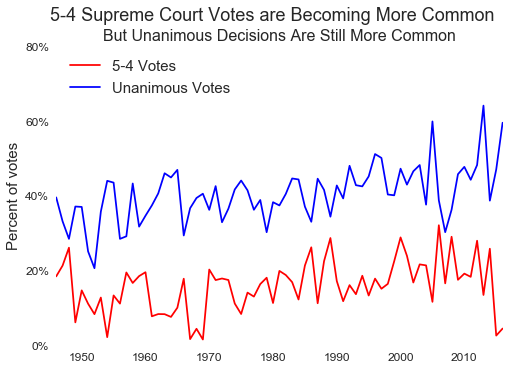

In [343]:
plt.plot(caseCentricTerm['term'],caseCentricTerm['4-5%'], c = 'red', label = '5-4 Votes')
plt.plot(caseCentricTerm['term'],caseCentricTerm['9-0%'], c = 'blue', label = 'Unanimous Votes')
plt.legend(loc = 'upper left', fontsize = 15)
plt.ylim(0,.6)
plt.ylabel("Percent of votes", fontsize = 15)
plt.xticks(fontsize = 12)
plt.yticks([0,.2,.4,.6,.8],['0%','20%','40%','60%','80%'], fontsize = 12)
plt.suptitle("5-4 Supreme Court Votes are Becoming More Common", fontsize = 18)
plt.title("But Unanimous Decisions Are Still More Common", fontsize = 16)
plt.axvspan(caseCentricTerm['term'].min(), caseCentricTerm['term'].max(), facecolor='w')
plt.xlim(caseCentricTerm['term'].min(), 2016)
plt.show()

## Merging Justice Centered Case Data and Martin-Quinn Score Data

In [383]:
# http://scdb.wustl.edu/data.php --> II. Justice Centered Data --> 1. Cases Organized by Supreme Court Citation
data = pd.read_csv("SCDB_2017_01_justiceCentered_Citation.csv.zip", encoding = 'latin')

# http://mqscores.lsa.umich.edu/measures.php --> THE 2016 JUSTICE DATA FILES
measures = pd.read_csv("justices.csv")

# merge justice votes and justice martin-quinn scores together
dataWithMeasures = pd.merge(data, measures, how='inner', left_on=['justiceName','year'], right_on = ['justiceName','term'])

dataWithMeasures = dataWithMeasures.sort_values('caseId')
dataWithMeasures = dataWithMeasures.reset_index()
del dataWithMeasures['index']
dataWithMeasures.tail(2)

,caseId,docketId,caseIssuesId,voteId,dateDecision,decisionType,usCite,sctCite,ledCite,lexisCite,...,secondAgreement,politicalParty,year,term_y,justice_y,post_mn,post_sd,post_med,post_025,post_975
75988,2016-042,2016-042-01,2016-042-01-01,2016-042-01-01-01-06,12/12/2016,1,NaN,NaN,NaN,2016 U.S. LEXIS 7431,...,0.0,R,2016,2016,112,1.476,0.392,1.459,0.756,2.298
75989,2016-042,2016-042-01,2016-042-01-01,2016-042-01-01-01-08,12/12/2016,1,NaN,NaN,NaN,2016 U.S. LEXIS 7431,...,0.0,D,2016,2016,114,-1.532,0.397,-1.517,-2.364,-0.798


## Sort and Group by Unique Case

In [ ]:
# sort dataWithMeasures by caseId and save as data2
data2 = dataWithMeasures.sort_values(by='caseId')
data2 = data2.reset_index()
del data2['index']

# group data2 by caseId and save as data3 - this will be used in subsequent merging step
data3 = data2.groupby('caseId').mean()
data3 = data3.reset_index()
del data3['index']

# determine difference between # of majority votes and # of minority votes
data3['majMinusMin'] = data3['majVotes'] - data3['minVotes']

## Assigning Liberal & Conservative Votes

In [ ]:
# Creating and initating 4 dummy variables
# Exactly one and only one dummy will = 1 for each row (which represents a justice vote on a case), while others will = 0 

data2['L1'] = 0 # Liberal justice, majority vote
data2['L2'] = 0 # Liberal justice, minority vote
data2['C1'] = 0 # Conservative justice, majority vote
data2['C2'] = 0 # Conservative justice, minority vote

for vote in range(0, len(data2)-1):
    
    if (data2['vote'][vote] == 1.0) & (data2['post_mn'][vote] < 0):
        data2['L1'][vote] = 1
    elif (data2['vote'][vote] == 2.0) & (data2['post_mn'][vote] < 0):
        data2['L2'][vote] = 1
    elif (data2['vote'][vote] == 1.0) & (data2['post_mn'][vote] > 0):
        data2['C1'][vote] = 1
    elif (data2['vote'][vote] == 2.0) & (data2['post_mn'][vote] > 0):
        data2['C2'][vote] = 1

In [ ]:
# group data2 by case ID on a sum
votes = data2.groupby(by = "caseId").sum()

# select only caseID and party vote counts and save as votes2
votes2 = votes.loc[:,['L1','L2','C1','C2']]
votes2 = votes2.reset_index()

# merge votes2 and data3, save as data4
data4 = data3.merge(votes2)

In [248]:
data4.head(3)

,caseId,decisionType,term_x,naturalCourt,petitioner,petitionerState,respondent,respondentState,jurisdiction,adminAction,...,post_975,majMinusMin,L1,L2,C1,C2,partyLineVote,4-5,9-0,place
0,1946-001,1.0,1946.0,1301.0,198.0,NaN,172.0,NaN,6.0,NaN,...,0.074889,7.0,4,0,3,1,0,0,0,1
1,1946-002,1.0,1946.0,1301.0,100.0,NaN,27.0,NaN,1.0,NaN,...,0.074889,3.0,1,2,4,1,0,0,0,1
2,1946-003,1.0,1946.0,1301.0,209.0,NaN,27.0,NaN,2.0,66.0,...,0.074889,1.0,3,1,2,3,0,1,0,1


## Plotting Average Difference in Voting Coalition Sizes Over Time

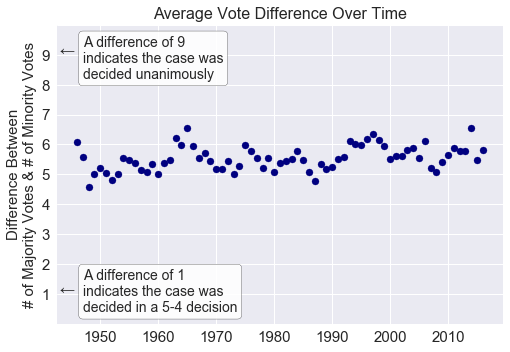

In [347]:
voteDiffOverTerm = data4.groupby('term_y').mean()

props = dict(boxstyle='round', facecolor='white', alpha=0.9)

plt.scatter(voteDiffOverTerm['term_y'],voteDiffOverTerm['majMinusMin'], c='navy')
plt.ylim(0,10)
plt.ylabel("Difference Between\n# of Majority Votes & # of Minority Votes",fontsize=15)
plt.xticks(fontsize=15)
plt.yticks([0,1,2,3,4,5,6,7,8,9,10],['','1','2','3','4','5','6','7','8','9'],fontsize=15)
plt.text(1947,0.4,"A difference of 1\nindicates the case was\ndecided in a 5-4 decision",ha='left',fontsize = 14,bbox=props)
plt.text(1947,8.2,"A difference of 9\nindicates the case was\ndecided unanimously",ha='left',fontsize=14,bbox=props)
plt.text(1943,1,"←", fontsize=15)
plt.text(1943,9,"←",fontsize=15)
plt.title("Average Vote Difference Over Time",fontsize = 16)
plt.show()

## Determining If Each Case Was a 'Party-Line' Vote / 4-5 Vote / 9-0 Vote

In [ ]:
data4['partyLineVote'] = 0
data4['4-5'] = 0
data4['9-0'] = 0

for vote in range(0,len(data4)):
    
    # Creating dummy - 1 if 'party line' vote, 0 otherwise
    if data4['C1'][vote] + data4['C2'][vote] > 0:
        if (data4['C1'][vote] == 0) | (data4['C2'][vote] == 0):
            if (data4['L1'][vote] == 0) | (data4['L2'][vote] == 0):
                if (data4['L1'][vote] != data4['C1'][vote]) & (data4['L2'][vote] != data4['C2'][vote]):
                    data4['partyLineVote'][vote] = 1
    
    # dummy if it was a 4-5 decision or not
    if data4['majMinusMin'][vote] == 1:
        data4['4-5'][vote] = 1
        
    # dummy if it was a 9-0 decision or not
    if data4['majMinusMin'][vote] == 9:
        data4['9-0'][vote] = 1
        
data4['place'] = 1

## Calculating Average Term Stats then Plotting % of Party-Line Votes Over Time

In [326]:
data6 = data4.groupby('term_y').sum() # this will result in totals of each variable by year
data6 = data6.reset_index()
data6['partyLineVote%'] = data6['partyLineVote'] / data6['place']
data6['4-5%'] = data6['4-5'] / data6['place']
data6['9-0%'] = data6['9-0'] / data6['place']

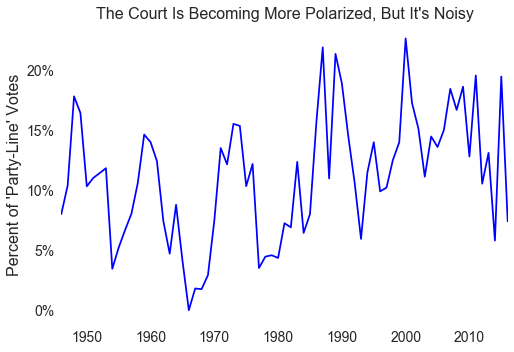

In [338]:
plt.plot(data6['term_y'],data6['partyLineVote%'],color='blue')
plt.ylabel("Percent of 'Party-Line' Votes", fontsize = 16)
plt.xticks(fontsize = 14)
plt.yticks([0,.05,.1,.15,.2],['0%','5%','10%','15%','20%'], fontsize = 14)
plt.title("The Court Is Becoming More Polarized, But It's Noisy", fontsize = 16)
plt.axvspan(data6['term_y'].min(), data6['term_y'].max(), facecolor='w')
plt.xlim(data6['term_y'].min(), data6['term_y'].max())
plt.show()

## Updating Above Plot to Show 'No Kennedy' Scenario

In [224]:
data2NoKennedy = data2[data2['justiceName'] != 'AMKennedy']

# group by case ID, on a sum
votesNoKennedy = data2NoKennedy.groupby(by = "caseId").sum()

# select only caseID and party vote counts
votesNoKennedy2 = votesNoKennedy.loc[:,['L1','L2','C1','C2']]
votesNoKennedy2 = votesNoKennedy2.reset_index()

# merge with data3
data4NoKennedy = data3.merge(votesNoKennedy2)

# Loop to determine if court decision was a party-line vote
data4NoKennedy['partyLineVote'] = 0

for vote in range(0,len(data4NoKennedy)):
    
    # Creating dummy - 1 if 'party line' vote, 0 otherwise
    if data4NoKennedy['C1'][vote] + data4NoKennedy['C2'][vote] > 0:
        if (data4NoKennedy['C1'][vote] == 0) | (data4NoKennedy['C2'][vote] == 0):
            if (data4NoKennedy['L1'][vote] == 0) | (data4NoKennedy['L2'][vote] == 0):
                if (data4NoKennedy['L1'][vote] != data4NoKennedy['C1'][vote]) & (data4NoKennedy['L2'][vote] != data4NoKennedy['C2'][vote]):
                    data4NoKennedy['partyLineVote'][vote] = 1
                    
data4NoKennedy['place'] = 1

data6noKennedy = data4NoKennedy.groupby('term_y').sum()
data6noKennedy = data6noKennedy.reset_index()

data6noKennedy['partyLineVote%'] = data6noKennedy['partyLineVote'] / data6noKennedy['place']

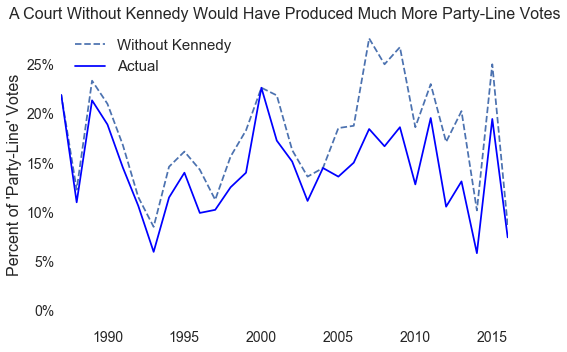

In [339]:
plt.plot(data6noKennedy['term_y'],data6noKennedy['partyLineVote%'], label='Without Kennedy', linestyle = 'dashed')
plt.plot(data6['term_y'],data6['partyLineVote%'],color='blue',label='Actual')
plt.ylabel("Percent of 'Party-Line' Votes", fontsize = 16)
plt.xticks(fontsize = 14)
plt.yticks([0,.05,.1,.15,.2,.25],['0%','5%','10%','15%','20%','25%'], fontsize = 14)
plt.title("A Court Without Kennedy Would Have Produced Much More Party-Line Votes", fontsize = 16)
plt.axvspan(data6['term_y'].min(), data6['term_y'].max(), facecolor='w')
plt.xlim(1987, data6['term_y'].max())
plt.legend(loc='best',fontsize = 15)
plt.show()

## How Often Did Each 2016 Justice Win In a 5-4 Vote?

In [ ]:
data2['majMinusMin'] = data2['majVotes'] - data2['minVotes']

# Dummy variable; 1 if the case was a 5-4 vote and the justice voted in majority, 0 otherwise
data2['votedMajIn5-4'] = 0

for case in range(0,20):
    if data2['majMinusMin'][case] == 1: # it was a 5-4 vote
        if data2['vote'][case] == 1: # justice voted with majority or plurality
            data2['votedMajIn5-4'][case] = 1

In [ ]:
# List of justices in 2016
justices = ['AMKennedy','CThomas','EKagan','JGRoberts','AScalia','RBGinsburg','SAAlito','SGBreyer','SSotomayor']

numCases = []
votedMajInSplit = []
per = []

for justice in justices:
    
    # subset data2 to include only votes cast by the current justice and in 5-4 decisions
    justiceVotes = data2[(data2['justiceName'] == justice) & (data2['majMinusMin'] == 1)]
    # how many instances they voted in a 5-4
    numCases.append(len(justiceVotes))
    # how many instances they voted in the majority
    votedMajInSplit.append(justiceVotes['votedMajIn5-4'].sum())
    # majority votes / total votes
    per.append(justiceVotes['votedMajIn5-4'].sum() / len(justiceVotes))

justiceSplits = pd.DataFrame({'justice':justices,'numCases':numCases,'votedMajInCloseVote':votedMajInSplit,'per':per})

justiceSplits = justiceSplits.sort_values(by='per')
justiceSplits = justiceSplits.reset_index()
del justiceSplits['index']
justiceSplits = justiceSplits.reset_index()

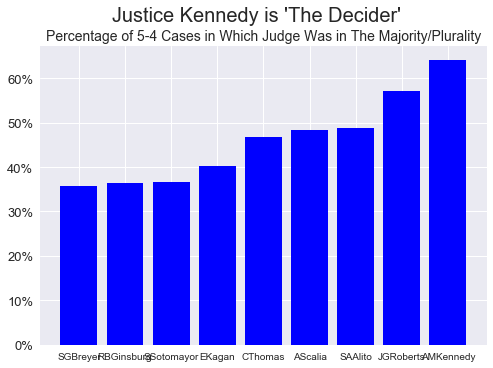

In [412]:
plt.bar(justiceSplits['index'],justiceSplits['per'],color='blue')
plt.xticks([0,1,2,3,4,5,6,7,8],list(justiceSplits['justice']))
plt.suptitle("Justice Kennedy is 'The Decider'", fontsize = 20)
plt.title("Percentage of 5-4 Cases in Which Judge Was in The Majority/Plurality", fontsize = 14)
plt.yticks([0,.1,.2,.3,.4,.5,.6],['0%','10%','20%','30%','40%','50%','60%'], fontsize = 13)
plt.show()